In [4]:
# ! pip uninstall tensorflow --yes
# ! pip uninstall keras --yes
# ! pip install tensorflow-gpu==2.3.0
# ! pip install keras
# ! pip install tensorflow_model_optimization

In [5]:
import keras
import numpy as np
from keras import Sequential, Model
from keras.layers import Conv2D, GlobalAvgPool2D, AvgPool2D, MaxPool2D, Flatten, Dense, Softmax, DepthwiseConv2D, BatchNormalization, ReLU
from keras.preprocessing import image
from tensorflow import lite
import pandas as pd
from PIL import Image
import tensorflow_model_optimization as tfmot
from matplotlib import pyplot as plt

import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Building model.
The structure of MobileNet_v1 is shown in the figure below:  
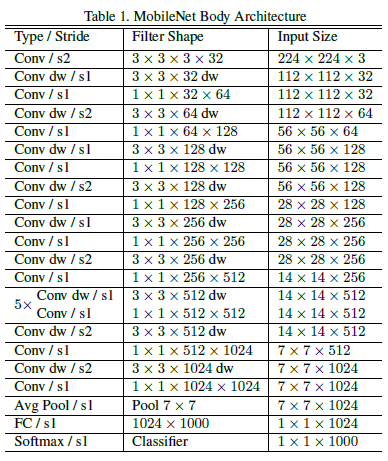  
The original model has 1000 classes to be predicted. but in GTSRB dataset, there are only 43 classes to be predicted. So in the final layer, I use `model.add(Dense(43))`.

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=2, input_shape=(224, 224, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(64, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(128, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(128, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(512, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
for i in range(5):
    model.add(DepthwiseConv2D((3, 3), strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(512, (1, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(1024, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(1024, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(AvgPool2D((7, 7)))
model.add(GlobalAvgPool2D())
model.add(Flatten())
model.add(Dense(43))
model.add(Softmax())

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_27 (Ba  (None, 112, 112, 32)      128       
 tchNormalization)                                               
                                                                 
 re_lu_27 (ReLU)             (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d_13 (Depth  (None, 112, 112, 32)      320       
 wiseConv2D)                                                     
                                                                 
 batch_normalization_28 (Ba  (None, 112, 112, 32)      128       
 tchNormalization)                                               
                                                      

                                                                 
 batch_normalization_43 (Ba  (None, 14, 14, 512)       2048      
 tchNormalization)                                               
                                                                 
 re_lu_43 (ReLU)             (None, 14, 14, 512)       0         
                                                                 
 depthwise_conv2d_21 (Depth  (None, 14, 14, 512)       5120      
 wiseConv2D)                                                     
                                                                 
 batch_normalization_44 (Ba  (None, 14, 14, 512)       2048      
 tchNormalization)                                               
                                                                 
 re_lu_44 (ReLU)             (None, 14, 14, 512)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 14, 14, 512)       262656    
          

## Generate the dataset.

C:\Users\ACER\AppData\Local\Temp\ipykernel_16588\911197901.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainDataFrame['ClassId'][i] = '0' + trainDataFrame['ClassId'][i]
C:\Users\ACER\AppData\Local\Temp\ipykernel_16588\911197901.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDataFrame['ClassId'][i] = '0' + testDataFrame['ClassId'][i]


20 Train/20/00020_00000_00020.png


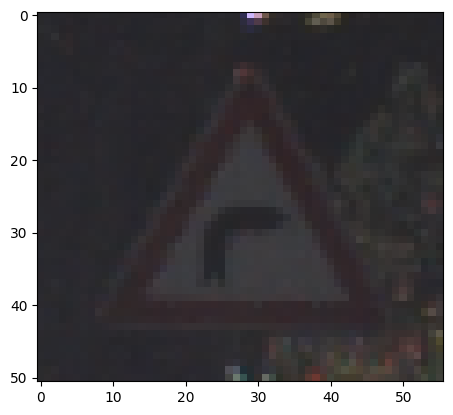

In [8]:
trainDataFrame = pd.read_csv('./gtsrb-german-traffic-sign/Train.csv')
testDataFrame = pd.read_csv('./gtsrb-german-traffic-sign/Test.csv')

trainDataFrame['ClassId'] = trainDataFrame['ClassId'].astype(str)
testDataFrame['ClassId'] = testDataFrame['ClassId'].astype(str)

for i in range(0, len(trainDataFrame['ClassId'])):
    if len(trainDataFrame['ClassId'][i]) == 1:
        trainDataFrame['ClassId'][i] = '0' + trainDataFrame['ClassId'][i]
for i in range(0, len(testDataFrame['ClassId'])):
    if len(testDataFrame['ClassId'][i]) == 1:
        testDataFrame['ClassId'][i] = '0' + testDataFrame['ClassId'][i]

print(trainDataFrame['ClassId'][20], trainDataFrame['Path'][20])
img = Image.open('./gtsrb-german-traffic-sign/' + trainDataFrame['Path'][20])
plt.imshow(img)

In [11]:
trainDataGen = image.ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)
testDataGen = image.ImageDataGenerator(

)

trainDataGenerator = trainDataGen.flow_from_dataframe(
    dataframe=trainDataFrame,
    directory='./gtsrb-german-traffic-sign/',
    x_col='Path',
    y_col='ClassId',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)
testDataGenerator = testDataGen.flow_from_dataframe(
    dataframe=testDataFrame,
    directory='./gtsrb-german-traffic-sign/',
    x_col='Path',
    y_col='ClassId',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 39209 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


## Train model.

In [14]:
history = model.fit(
    trainDataGenerator,
    steps_per_epoch=10, #500
    epochs=16,
    validation_data=testDataGenerator,
#     validation_steps=800,
    verbose=1) 

Epoch 1/16
10/10 [==============================] - 328s 36s/step - loss: 2.9146 - accuracy: 0.1719 - val_loss: 3.9001 - val_accuracy: 0.0380
Epoch 2/16
10/10 [==============================] - 328s 36s/step - loss: 2.9117 - accuracy: 0.1781 - val_loss: 3.9167 - val_accuracy: 0.0214
Epoch 3/16
 8/10 [=======================>......] - ETA: 11s - loss: 2.8749 - accuracy: 0.2012

KeyboardInterrupt: 

## Evaluate model.

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']
epoches = range(0, len(loss))
plt.plot(epoches, loss, 'b', label='training loss')
plt.legend()
plt.figure()
plt.plot(epoches, acc, 'g', label='training accuracy')
plt.legend()
plt.show()

In [ ]:
model.evaluate(testDataGenerator, verbose=1)

In [ ]:
test_batch = 2
plt.figure(figsize=(64, 64))
plt.tight_layout()
for i in range(0, 16):
    plt.subplot(16, 2, 2 * i + 1), plt.axis('off')
    plt.imshow(testDataGenerator[test_batch][0][i])
    pre = model.predict_classes(testDataGenerator[test_batch][0])
    img = Image.open('./gtsrb-german-traffic-sign/Meta/' + str(pre[i]) + '.png')
    plt.subplot(16, 2, 2 * i + 2), plt.axis('off')
    plt.imshow(img)

## Quantize

If you want to deploy the model on IoT devices or edge devices, you may think of quantized model to minimize the size of the model.

### Quantized model build.

In [ ]:
quantize_model = tfmot.quantization.keras.quantize_model

q_aware_model = quantize_model(model)

q_aware_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

q_aware_model.summary()

### Quantized model train.

In [ ]:
q_aware_model.fit(
    trainDataGenerator, 
    steps_per_epoch=500, 
    epochs=10, 
    verbose=1
)

### Evaluate quantized model.

In [ ]:
q_aware_model.evaluate(testDataGenerator, verbose=1)

## Save models.

In [ ]:
model.save('./models/MobileNet.h5')
model.save_weights('models/MobileNet_weights.h5')
q_aware_model.save('models/MobileNet_quantized.h5')
q_aware_model.save('models/MobileNet_quantized_weights.h5')

## Convert the models into tflite model.

In [ ]:
converter = lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [lite.Optimize.DEFAULT]
tfliteModel = converter.convert()
open('model/final/MobileNet.tflite', 'wb').write(tfliteModel)